In [1]:
# Before we begin, we supress deprecation warnings resulting from nltk on Kaggle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Sentiment classification on tweets about airlines

This notebook describes an attempt to classify tweets by sentiment. It describes the initial data exploration, as well as implementation of a classifier.

## What is in the dataset?

It's always good to start by exploring the data that we have available. To do this we load the raw csv file using [Pandas][1] and check what the columns are.

  [1]: http://pandas.pydata.org/

In [3]:
import pandas as pd
tweets = pd.read_csv("./data/tweets.csv")
list(tweets.columns.values)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

We want to be able to determine the sentiment of a tweet without any other information but the tweet text itself, hence the 'text' column is our focus. Using the text we are going to try and predict 'airline_sentiment'.

Lets take a look at what a typical record looks like.

In [4]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Lets take a look at what sentiments have been found.

In [5]:
sentiment_counts = tweets.airline_sentiment.value_counts()
number_of_tweets = tweets.tweet_id.count()
print(sentiment_counts)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


It turns out that our dataset is unbalanced with significantly more negative than positive tweets. We will focus on the issue of separating positive and negative tweets, ignore the neutral ones. It's good to keep in mind that, while a terrible classifier, if we always guessed a tweet was negative we'd be right 79% of the time (9178 of 11541). That clearly wouldn't be a very useful classifier, but worth to remember.

# What characterizes text of different sentiments?

While we still haven't decided what classification method to use, it's useful to get an idea of how the different texts look. This might be an "old school" approach in the age of deep learning, but lets indulge ourselves nevertheless. 

To explore the data we apply some crude preprocessing. We will tokenize and lemmatize using [Python NLTK][1], and transform to lower case. As words mostly matter in context we'll look at bi-grams instead of just individual tokens.

### Preprocessing
Note that we remove the first two tokens as they always contain "@ airline_name".


  [1]: http://www.nltk.org/

In [6]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
negative_tweets = tweets.loc[rawData['airline_sentiment'] == 'negative'].text
def normalize_tweet(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in tokens[2:]]
    lower_case = [l.lower() for l in lemmas]
    filtered_result = list(filter(lambda l: l not in stop_words,lower_case))
    return filtered_result

preprocessed_negative_tweets = negative_tweets.apply(normalize_tweet)
print('Example preprocessed tweet:\n', preprocessed_negative_tweets.iloc[0])

Example preprocessed tweet:
 ['really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guest', 'face', 'amp', 'little', 'recourse']


In [8]:
from nltk import ngrams
def grams(tokens):
    return list(ngrams(tokens, 3))
negative_grams = preprocessed_negative_tweets.apply(grams)

And now some counting.

In [9]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

count_words(negative_grams).most_common(20)

[(('cancelled', 'flightled', 'flight'), 107),
 (('wa', 'cancelled', 'flightled'), 97),
 (('flight', 'wa', 'cancelled'), 70),
 (('flight', 'cancelled', 'flightled'), 60),
 (('cancelled', 'flight', 'flight'), 55),
 (('flight', 'booking', 'problems'), 54),
 (('cancelled', 'flighted', 'flight'), 49),
 (('hour', 'late', 'flight'), 37),
 (('reflight', 'booking', 'problems'), 36),
 (('worst', 'customer', 'service'), 34),
 (('flight', 'cancelled', 'flighted'), 31),
 (('hour', 'late', 'flightr'), 31),
 (('wa', 'cancelled', 'flighted'), 30),
 (('fleek', 'http', 'co'), 29),
 (('fleet', 'fleek', 'http'), 29),
 (('cancelled', 'flighting', 'flight'), 23),
 (('poor', 'customer', 'service'), 22),
 (('flight', 'wa', 'delayed'), 20),
 (('late', 'flightr', 'still'), 20),
 (('jetblue', 'fleet', 'fleek'), 19)]

We can already tell there's a pattern here. Sentences like "cancelled flight", "late flight", "booking problems",  "delayed flight" stand out clearly. Lets check the positive tweets.

In [10]:
positive_tweets = rawData.loc[tweets['airline_sentiment'] == 'positive'].text
preprocessed_positive_tweets = positive_tweets.apply(normalize_tweet)
positive_grams = preprocessed_positive_tweets.apply(grams)
count_words(positive_grams).most_common(20)

[(('fleek', 'http', 'co'), 14),
 (('fleet', 'fleek', 'http'), 14),
 (('keep', 'good', 'work'), 12),
 (('great', 'customer', 'service'), 12),
 (('excellent', 'customer', 'service'), 7),
 (('reflight', 'booking', 'problems'), 7),
 (('customer', 'service', 'today'), 6),
 (('jetblue', 'fleet', 'fleek'), 6),
 (('http', 'co', 'x'), 5),
 (('cancelled', 'flightled', 'flight'), 5),
 (('wa', 'cancelled', 'flightled'), 5),
 (('best', 'follow', 'please'), 5),
 (('love', 'flying', 'guy'), 5),
 (('amazing', 'customer', 'service'), 5),
 (('customer', 'service', 'rep'), 5),
 (('folk', 'cessna', 'become'), 4),
 (('work', 'folk', 'cessna'), 4),
 (('appreciate', 'prompt', 'response'), 4),
 (('best', 'customer', 'service'), 4),
 (('flight', 'wa', 'delayed'), 4)]

Some more good looking patterns here. We can however see that with 3-grams clear patterns are rare. "great customer service" occurs 12 times in 2362 positive responses, which really doesn't say much in general. 

Satisfied that our data looks possible to work with begin to construct our first classifier.

# First Classifier
Lets start simple with a bag-of-words Support-Vector-Machine (SVM) classifier. Bag-of-words means that we represent each sentence by the unique words in it. To make this representation useful for our SVM classifier we transform each sentence into a vector. The vector is of the same length as our vocabulary, i.e. the list of all words observed in our training data, with each word representing an entry in the vector. If a particular word is present, that entry in the vector is 1, otherwise 0.

To create these vectors we use the CountVectorizer from [sklearn][1]. Note that we make sure to have an index that mapps vectorized data back to the original sentence. This will come in handy when inspecting output from the classifier later.


  [1]: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## Preparing the data

In [11]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
negative_data = preprocessed_negative_tweets.apply(' '.join).as_matrix().tolist()
positive_data = preprocessed_positive_tweets.apply(' '.join).as_matrix().tolist()
negative_targets = np.zeros((len(negative_data),1))
positive_targets = np.ones((len(positive_data),1))
raw_data = negative_data+positive_data
vectorized_data = count_vectorizer.fit_transform(raw_data)
targets = np.concatenate((negative_targets,positive_targets), axis=0).ravel()
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

To check performance of our classifier we want to split our data in to train and test.

In [12]:
from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

## Fitting a classifier

We're now ready to fit a classifier to our data. We'll spend more time on hyper parameter tuning later, so for now we just pick some reasonable guesses.

In [13]:
from sklearn import svm
clf = svm.SVC(gamma=0.01, C=100., probability=True)
clf_settings = clf.fit(data_train, targets_train)

## Evaluation of results

In [14]:
clf.score(data_test, targets_test)

0.8702620749404375

87% likely isn't great, but it's not nothing. It's most likely possible to achieve a higher score with more tuning, or a more advanced approach. Lets check on how it does on a couple of sentences.

In [15]:
sentences = count_vectorizer.transform([
    "What a great airline, the trip was a pleasure!",
    "My issue was quickly resolved after calling customer support. Thanks!",
    "What the hell! My flight was cancelled again. This sucks!",
    "Service was awful. I'll never fly with you again.",
    "You fuckers lost my luggage. Never again!",
    "I have mixed feelings about airlines. I don't know what I think.",
    ""
])
clf.predict_proba(sentences)

array([[ 0.05134708,  0.94865292],
       [ 0.02727517,  0.97272483],
       [ 0.97591708,  0.02408292],
       [ 0.92518752,  0.07481248],
       [ 0.98713239,  0.01286761],
       [ 0.44058996,  0.55941004],
       [ 0.45826658,  0.54173342]])

So while not a huge improvement over the baseline, we can see that it's doing a good job on these obvious sentences. 

## What is hard for the classifier?

It's interesting to know which sentences are hard. To find out, lets apply the classifier to all our test sentences and sort by the marginal probability.

In [16]:
predictions_on_test_data = np.array(clf.predict_proba(data_test))
index = np.transpose(np.array([range(0,len(predictions_on_test_data))]))
indexed_predictions = np.concatenate((predictions_on_test_data, index), axis=1).tolist()
marginal_probability = sorted(list(map(lambda p : [abs(p[0]-p[1]), p[2]], indexed_predictions)), key=lambda p : p[0])
list(map(lambda p : raw_data[data_test_index[p[1]].toarray()[0][0]], marginal_probability[0:10]))

['selfie',
 'heartlanta',
 'aal declared state emergency squawking',
 'think best first class ever gotten denver lax wonderful',
 'sloooooow today',
 'thanks charging switching two cancelled flightled flight anyway wa pretty nice stillmakingmepoorthough',
 'course work virginatlantic obsessed entire virgin family',
 'lo',
 'scheduled',
 'loyalmosaicmember']

How about the easiest test sentences?

In [17]:
list(map(lambda p : raw_data[data_test_index[p[1]].toarray()[0][0]], marginal_probability[-10:]))

['hold hour min trying find luggage flight cancelled flightled luggage http co sfmi zat',
 'suck worst airline ever never flying stuck hour one helping fuckoff',
 'jfk flight boston delayed min waiting catering boarding flight lax waiting hour wtf',
 'best message saying use website website saying need call answer hardtodo',
 'hold another hour still nothing cancelled flighted flight wa supposed six hour stranded',
 'cancelled flightled website say call phone number phone say check online supposed get help',
 'delayed hour one hour flight frustrating also unable get decent meal hour never',
 'hold hour system hung twice hour holding trying correct online flight booking problems error unhappy',
 'much awesome support guy rock',
 'hour luggage line long left airport flight cancelled flighted doe luggage go hold hour far']

In [18]:
list(map(lambda p : clf.predict_proba(data_test[p[1]]), marginal_probability[-10:]))

[array([[  9.99964139e-01,   3.58611627e-05]]),
 array([[  9.99965328e-01,   3.46719136e-05]]),
 array([[  9.99965608e-01,   3.43920579e-05]]),
 array([[  9.99966452e-01,   3.35484904e-05]]),
 array([[  9.99971583e-01,   2.84169951e-05]]),
 array([[  9.99975490e-01,   2.45098891e-05]]),
 array([[  9.99984369e-01,   1.56306126e-05]]),
 array([[  9.99984671e-01,   1.53285214e-05]]),
 array([[  6.70194062e-06,   9.99993298e-01]]),
 array([[  9.99995815e-01,   4.18495118e-06]])]

What is the distribution of certainty?

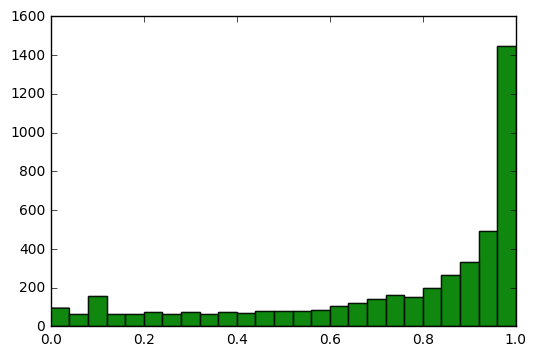

In [20]:
import matplotlib.pyplot as plt
marginal_probs = list(map(lambda p : p[0], marginal_probability))
n, bins, patches = plt.hist(marginal_probs, 25, facecolor='green', alpha=0.75)
plt.show()

Lets break it down by positive and negative sentiment to see if one is harder than the other.

### Positive data

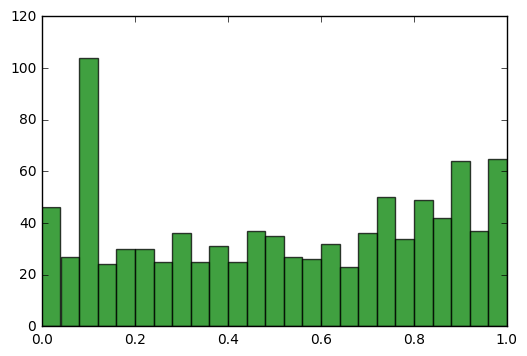

In [23]:
positive_test_data = list(filter(lambda row : row[0]==1, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : abs(p[0]-p[1]), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='green', alpha=0.75)
plt.show()

### Negative data

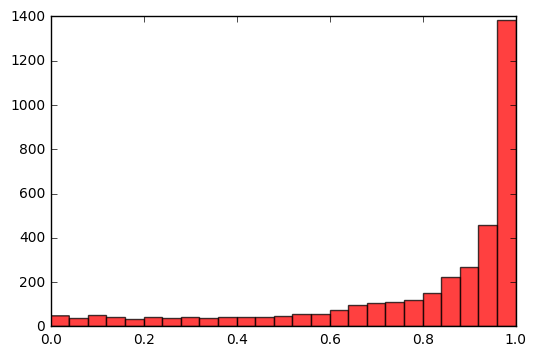

In [25]:
negative_test_data = list(filter(lambda row : row[0]==0, hstack((targets_test[:,None], data_test)).toarray()))
negative_probs = clf.predict_proba(list(map(lambda r : r[1:], negative_test_data)))
marginal_negative_probs = list(map(lambda p : abs(p[0]-p[1]), negative_probs))
n, bins, patches = plt.hist(marginal_negative_probs, 25, facecolor='red', alpha=0.75)
plt.show()

Clearly the positive data is much harder for the classifier. This makes sense since there's a lot less of it. An important challenge in building a classifier will then be how to handle positive data.